In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))



Using cpu device


# Data generation

Geometrical figures of random position, shape and color

Random Color:


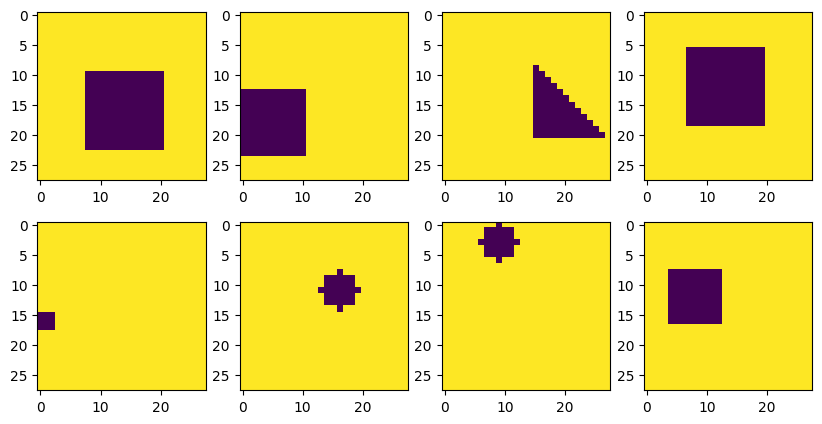

In [27]:


class GeometricFiguresDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=60000, image_size=(28, 28), random_color=True):
        self.num_samples = num_samples
        self.image_size = image_size
        self.random_color = random_color

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_image()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        label_tensor = torch.tensor(label)
        return image_tensor, label_tensor

    def generate_image(self):
        image = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.uint8) * 255  # White background

        shape = np.random.choice(['square', 'circle', 'triangle'])
        color = self.choose_color()
        size = np.random.randint(3, self.image_size[0] // 2)
        pos_x = np.random.randint(0, self.image_size[1] - size)
        pos_y = np.random.randint(0, self.image_size[0] - size)

        if shape == 'square':
            image = self.draw_square(image, x = pos_x, y = pos_y,  size=size, color=color)
        elif shape=='circle':
            image = self.draw_circle(image, x = pos_x, y = pos_y, radius=size//2, color=color)
        else:
            image = self.draw_triangle(image, x = pos_x, y = pos_y, size=size, color=color)

        #label is the shape, color, size and position of the shape
        shape_dict = {'square': 0, 'circle': 1, 'triangle': 2}
        label = np.array([shape_dict[shape],  size, pos_x, pos_y, color[0], color[1], color[2]])


        return image, label

    def choose_color(self):
        if self.random_color:
            return np.random.randint(0, 256, size=3)  # Random RGB color
        else:
            color_r = np.array([255, 0, 0])
            color_g = np.array([0, 255, 0])
            color_b = np.array([0, 0, 255])
            rand_col = np.random.randint(0, 3)
            if rand_col == 0:
                return color_r
            elif rand_col == 1:
                return color_g
            else:
                return color_b


    def draw_square(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color
        return image

    def draw_triangle(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color

        # Determine whether to remove upper or lower half of the square
        if np.random.rand() < 0.5:
            # Remove upper half of the square
            for i in range(size):
                for j in range(size):
                    if i > j:
                        image[y+i, x+j] = 255  # Background color
        else:
            # Remove lower half of the square
            for i in range(size):
                for j in range(size):
                    if i < j:
                        image[y+i, x+j] = 255  # Background color
        return image

    def draw_circle(self, image, x, y, radius, color):

        yy, xx = np.ogrid[-y:image.shape[0]-y, -x:image.shape[1]-x]
        mask = xx*xx + yy*yy <= radius*radius
        image[mask] = color
        return image


class GeometricFiguresDatasetBlackWhite(GeometricFiguresDataset):
    def __init__(self, num_samples=60000, image_size=(28, 28)):
        super().__init__(num_samples, image_size, random_color=False)

    def choose_color(self):
        return np.array([0, 0, 0])  # Black color

    def __getitem__(self, idx):
        img, label =  super().__getitem__(idx)
        #img = img[0]  # Take only one channel
        #leave only one channel
        img = img[0].unsqueeze(0)
        #img = img/255.0  # Normalize
        return img, label




dataset_random_color = GeometricFiguresDatasetBlackWhite()
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=8, shuffle=True)

# Visualize some samples with random color
print("Random Color:")
for batch in dataloader_random_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch


In [28]:
batch_size = 128

data_geom = torch.utils.data.DataLoader(GeometricFiguresDatasetBlackWhite(), batch_size=batch_size, shuffle=True)


In [29]:
data_mnist = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=batch_size,
        shuffle=True)

In [30]:
data = data_geom

# MNIST only

In [31]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        curr_loss = 0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            curr_loss += loss.item()
        
        print(f"Epoch {epoch+1} Loss: {curr_loss/len(data)}")
    return autoencoder

latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU


autoencoder = train(autoencoder, data)


Epoch 1 Loss: 5297.041658511294
Epoch 2 Loss: 3695.8982641549505
Epoch 3 Loss: 3286.7247119244735
Epoch 4 Loss: 3083.0047235224547
Epoch 5 Loss: 2931.380601179371
Epoch 6 Loss: 2845.0306136206523
Epoch 7 Loss: 2774.9350367304105
Epoch 8 Loss: 2732.8687939349015
Epoch 9 Loss: 2685.1610037146856
Epoch 10 Loss: 2639.995150503065
Epoch 11 Loss: 2565.226079164029
Epoch 12 Loss: 2558.5986687308437
Epoch 13 Loss: 2551.660873055204
Epoch 14 Loss: 2507.1061056499034
Epoch 15 Loss: 2475.453685378215
Epoch 16 Loss: 2468.179327535731
Epoch 17 Loss: 2429.026054333522
Epoch 18 Loss: 2422.245786622135
Epoch 19 Loss: 2362.868214296125
Epoch 20 Loss: 2363.605904455124


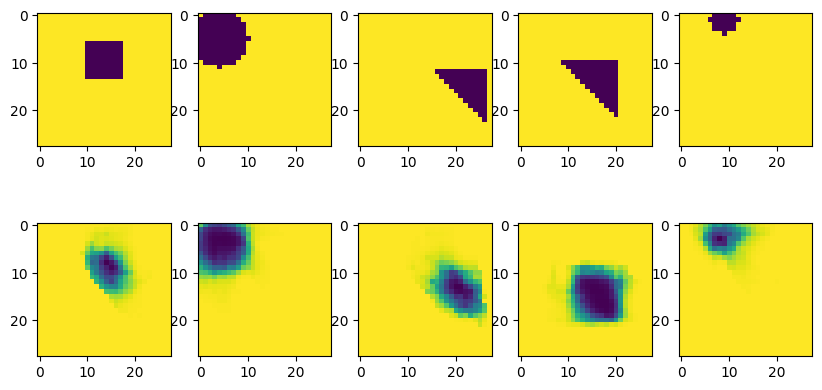

In [32]:
random_batch = next(iter(data))
random_batch = random_batch[0].to(device)
output = autoencoder(random_batch)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


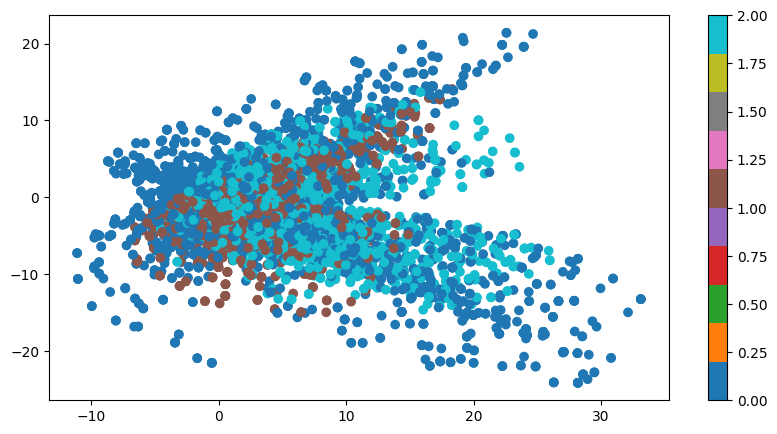

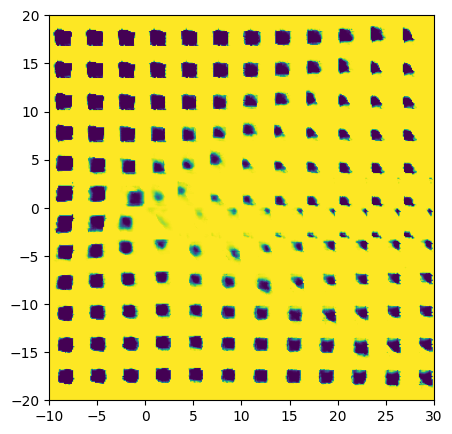

In [38]:
%matplotlib inline
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        y = y.to('cpu').detach().numpy()[:, 0]
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plt.figure(figsize=(10, 5))
plot_latent(autoencoder, data)


def plot_reconstructed(autoencoder, r0=(-10, 30), r1=(-20, 20), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plt.figure(figsize=(10, 5))
plot_reconstructed(autoencoder)
